In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [164]:
import torch
from torch import nn

: 

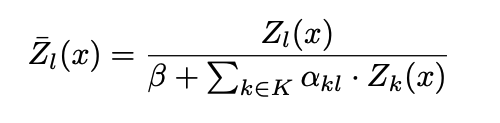

In [116]:
bank_size=512

In [ ]:
# 512^2 kernels. scale, two means, two variances, rotation
        # = 6 parameters per kernel.
        params = torch.rand(self.bank_size, self.bank_size, 6)

In [117]:
# initialise parameters tensor (512,512,6):
params = torch.rand(bank_size,bank_size,6)

In [118]:
in_size = 51

def gaussianKernel(theta, v, w, rho, sigma, A, x=torch.linspace(-1,1,in_size)):

    Sigma = torch.diag(torch.Tensor([rho, sigma]))
    mu = torch.Tensor([v,w])

    # x = torch.arange(0, in_size)

    x, y = torch.meshgrid(x, x)

    x_rot = x * torch.cos(theta) + y * torch.sin(theta)
    y_rot = -x * torch.sin(theta) + y * torch.cos(theta)

    pos = torch.zeros(x_rot.shape + (2,))
    pos[:, :, 0] = x_rot
    pos[:, :, 1] = y_rot

    const = A / (2 * torch.pi * rho * sigma)
    
    Sigma_inv = torch.inverse(Sigma)

    delta = torch.subtract(pos,mu)

    fac = torch.einsum('...k,kl,...l->...', delta, Sigma_inv, delta)

    return const * torch.exp(-fac / 2)

In [119]:
params[0][0]

tensor([0.1915, 0.6715, 0.2074, 0.1730, 0.2236, 0.6807])

In [121]:
kernels = torch.zeros(bank_size,bank_size,in_size,in_size)

for i in range(512):
    for j in range(512):
        kernels[i][j] = gaussianKernel(*params[i][j])

# for 51x51
# EVEN SLOWER ON GPU DUE TO FOR LOOP, COMPUTATION NEEDS TO OCCUR
# ON SINGLE-THREAD GPU AND ONLY ONCE.
# ISOLATE COMPUTATION OF KERNELS
47.0 / (512*512) # 0.18ms per kernel, but really blows at each computation.


0.000179290771484375

In [127]:
# Example tensors
filters_tensor = torch.randn(512, 512, 50, 50)
images_tensor = torch.randn(512, 50, 50)

In [128]:
# Expand the images_tensor along the second dimension to match the shape of the filters_tensor
expanded_images_tensor = images_tensor.unsqueeze(1).expand(-1, 512, -1, -1)

# Element-wise multiplication
result_tensor = filters_tensor * expanded_images_tensor

# Print the shape of the result tensor
print("Shape of the result tensor:", result_tensor.shape)

# this performs the row-wise filter correspondence in the vonenetdn paper
# ultimately the filter tensor is implicit in the normalisation process
# the orientation is unsubstantial

torch.all(result_tensor[0][1] == filters_tensor[0][1]*images_tensor[0])

Shape of the result tensor: torch.Size([512, 512, 50, 50])


tensor(True)

In [145]:
# this constitutes the sum term for the denominator
summed = torch.sum(result_tensor, dim=0)
beta = 1e-4
summed = summed + beta
summed.shape

torch.Size([512, 50, 50])

In [146]:
norm = images_tensor / summed
# filter-wise division works
torch.all(norm[0] == images_tensor[0] / summed[0])

tensor(True)

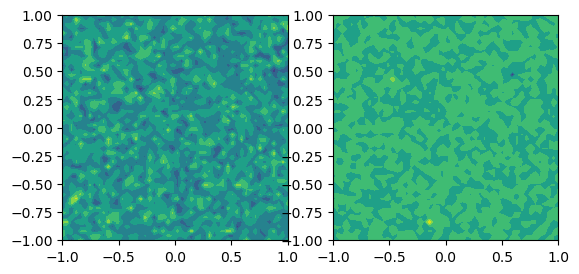

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

x=torch.linspace(-1,1,50)

fig, ax = plt.subplots(1,2)

gk1 = images_tensor[1]
gk2 = norm[1]
contourf1 = ax[0].contourf(x,x,gk1)
contourf2 = ax[1].contourf(x,x,gk2)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

In [6]:

# UPDATED FORM OF GAUSSIAN KERNEL FUNCTION

def gaussianKernel(theta, v, w, rho, sigma, A, in_size = 50):

    Sigma = torch.diag(torch.Tensor([rho, sigma]))
    mu = torch.Tensor([v,w])

    x = torch.linspace(-1,1,in_size)

    x, y = torch.meshgrid(x, x)

    x_rot = x * torch.cos(theta) + y * torch.sin(theta)
    y_rot = -x * torch.sin(theta) + y * torch.cos(theta)

    pos = torch.zeros(x_rot.shape + (2,))
    pos[:, :, 0] = x_rot
    pos[:, :, 1] = y_rot

    const = A / (2 * torch.pi * rho * sigma)
    
    Sigma_inv = torch.inverse(Sigma)

    delta = torch.subtract(pos,mu)

    fac = torch.einsum('...k,kl,...l->...', delta, Sigma_inv, delta)

    return const * torch.exp(-fac / 2)

# DIMENSIONS OF OUTPUT FROM VONEBLOCK MUST BE STORED SOMEWHERE!
# MAP FROM PARAMETERS TO FILTER!

class DNBlock(nn.Module):

    # initialise all parameters
    # compute denominator (bias plus params of kernels all trainable?)
    # bank size, image size
    # compute full expression
    # return

    def __init__(self, in_size, bank_size, beta=1e-4):
        super().__init__()

        self.in_size = in_size
        self.bank_size = bank_size
        self.kernel = gaussianKernel

        self.weights = torch.zeros((bank_size, bank_size, in_size, in_size))

        self.beta = beta

        self.initialize()


    def initialize(self):

        # 512^2 kernels. scale, two means, two variances, rotation
        # = 6 parameters per kernel
        params = torch.rand(self.bank_size, self.bank_size, 6)

        self.params = nn.Parameter(params, requires_grad = True)
        # enable autograd to accumulate across params


    def computeCoefficients(self):

        # NEEDS TO HAPPEN ON CPU!!!

        # self.weights = torch.zeros((bank_size, bank_size, in_size, in_size)) (IN INIT)

        x = torch.linspace(-1, 1, self.in_size, device="cpu")

        # I STILL EXPECT THIS TO BE VERY COSTLY.
        for i in range(self.bank_size):
            for j in range(self.bank_size):
                self.weights[i][j] = self.kernel(*params[i][j], in_size=self.in_size)

    def denominator(self,x):

        # neat trickery that enables weights matrix pointwise multiplication
        # in the same fashion that the denominator sum is described
        # in the original paper

        self.computeCoefficients()
        # re-computes the kernels accn. to current state of implicit
        # trainable parameters

        expanded_images_tensor = x.unsqueeze(1).expand(-1, bank_size, -1, -1)
        result_tensor = self.weights * expanded_images_tensor
        summed = torch.sum(result_tensor, dim=0)
        summed = summed + self.beta

        return summed

    def forward(self,x):

        den = self.denominator(x)

        return x / den
    


class VOneBlockDN(VOneBlock):

    def __init__(self, sf, theta, sigx, sigy, phase,
                 k_exc=25, noise_mode=None, noise_scale=1, noise_level=1,
                 simple_channels=128, complex_channels=128, ksize=25, stride=4, input_size=224):

        super().__init__(sf, theta, sigx, sigy, phase,
                 k_exc, noise_mode, noise_scale, noise_level,
                 simple_channels, complex_channels, ksize, stride, input_size)


        self.dn = DNBlock(in_size=64, bank_size=self.out_channels)
        self.dn.initialize()

    def forward(self, x):
        # Gabor activations [Batch, out_channels, H/stride, W/stride]
        x = self.gabors_f(x)
        # Noise [Batch, out_channels, H/stride, W/stride]
        x = self.noise_f(x)
        # V1 Block output: (Batch, out_channels, H/stride, W/stride)
        x = self.output(x)
        # DN output
        x = self.dn(x)

        return x

array([   0, 1000])

Issue with: Gaussian Kernels computed accurately but also every time a batch is run (img count / 128). Each batch iteration adds on 43s or so...